In [127]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [152]:
arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc"
alberto_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"
mosaic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/mosaic_ds.nc"
nice_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/nice_ds.nc"
HM_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/HM_ds.nc"
NN_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"

arctic_ds = xr.open_dataset(arctic_mix)
alberto_ds = xr.open_dataset(alberto_nc)
global_ds = pd.read_pickle(global_pkl)
global_nn = xr.open_dataset(global_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)
NN_ds = xr.open_dataset(NN_nc)

In [153]:
def check_coords(data):
    if "latitude" not in data.coords:
        data = data.set_coords("latitude")
    if "longitude" not in data.coords:
        data = data.set_coords("longitude")
    if "time" not in data.coords:
        data = data.set_coords("time")
    if "depth" not in data.coords:
        data["depth"] = data.depth
    return data

In [11]:
#arctic_ds = arctic_ds.rename({"TIME":"time"})
ds_list = [alberto_ds, mosaic_ds, HM_ds, arctic_ds]
[alberto_ds, mosaic_ds, HM_ds, arctic_ds] = [check_coords(ds) for ds in ds_list]
# Select depth range up to 300 meters
ds_lost = [ds.sel(depth=slice(None, 69)) for ds in [alberto_ds, mosaic_ds, HM_ds, arctic_ds]]

ValueError: These variables cannot be found in this dataset: ['time']

In [20]:
# Define the new profile indices for each dataset
alberto_profiles = np.arange(len(alberto_ds.profile))
mosaic_profiles = np.arange(len(alberto_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile))
HM_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile))
arctic_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile) + len(arctic_ds.profile))

# Rename the profile dimension to a new name for each dataset
alberto_ds = alberto_ds.rename(profile='alberto_profile')
mosaic_ds = mosaic_ds.rename(profile='mosaic_profile')
HM_ds = HM_ds.rename(profile='HM_profile')
arctic_ds = arctic_ds.rename(profile='arctic_profile')

# Reindex each dataset along the new profile dimension
alberto_ds = alberto_ds.reindex(alberto_profile=alberto_profiles)
mosaic_ds = mosaic_ds.reindex(mosaic_profile=mosaic_profiles)
HM_ds = HM_ds.reindex(HM_profile=HM_profiles)
arctic_ds = arctic_ds.reindex(arctic_profile=arctic_profiles)

# Rename the profile dimension back to 'profile'
alberto_ds = alberto_ds.rename(alberto_profile='profile')
mosaic_ds = mosaic_ds.rename(mosaic_profile='profile')
HM_ds = HM_ds.rename(HM_profile='profile')
arctic_ds = arctic_ds.rename(arctic_profile='profile')

# Concatenate the datasets along the 'profile' dimension
#ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='profile')

In [80]:
alberto_ds = alberto_ds.drop_vars('time')
mosaic_ds = mosaic_ds.drop_vars('time')
HM_ds = HM_ds.drop_vars('time')
arctic_ds = arctic_ds.drop_vars('time')

In [86]:
# define common coordinates across all datasets
coords = {"latitude": "lat", "longitude": "lon", "depth": "depth", "profile": "profile"}

In [82]:
# Combine the datasets into one dataset
ds_list = [alberto_ds, mosaic_ds, HM_ds, arctic_ds]

# Create a common depth grid
depth_min = 0  # minimum depth
depth_max = 2000  # maximum depth
depth_step = 1  # depth step size
depth_grid = np.arange(depth_min, depth_max+depth_step, depth_step)

# Resample the data onto the common depth grid
for i in range(len(ds_list)):
    ds_list[i] = ds_list[i].interp(depth=depth_grid, method='linear')

# Concatenate the datasets along the depth dimension
ds_combined = xr.combine_by_coords(ds_list, compat='override')

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'depth'}

In [73]:
ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='profile', join='override')

ValueError: cannot align objects with join='override' with matching indexes along dimension 'depth' that don't have the same size

In [72]:
# Determine unique depths across all datasets
unique_depths = np.unique(np.concatenate((alberto_ds.depth.values, mosaic_ds.depth.values, HM_ds.depth.values, arctic_ds.depth.values)))

# Reindex each dataset along the depth dimension
alberto_ds = alberto_ds.reindex(depth=unique_depths, method='nearest')
mosaic_ds = mosaic_ds.reindex(depth=unique_depths, method='nearest')
HM_ds = HM_ds.reindex(depth=unique_depths, method='nearest')
arctic_ds = arctic_ds.reindex(depth=unique_depths, method='nearest')

# Concatenate the datasets along the depth dimension

ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='depth')

ValueError: cannot reindex or align along dimension 'depth' because of conflicting dimension sizes: {440, 1903} (note: an index is found along that dimension with size=1903)

In [63]:
# Define the new profile indices for each dataset
alberto_profiles = np.arange(len(alberto_ds.profile))
mosaic_profiles = np.arange(len(alberto_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile))
HM_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile))
arctic_profiles = np.arange(len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile), len(alberto_ds.profile) + len(mosaic_ds.profile) + len(HM_ds.profile) + len(arctic_ds.profile))

# Rename the profile dimension to a new name for each dataset
alberto_ds = alberto_ds.rename(profile='alberto_profile')
mosaic_ds = mosaic_ds.rename(profile='mosaic_profile')
HM_ds = HM_ds.rename(profile='HM_profile')
arctic_ds = arctic_ds.rename(profile='arctic_profile')

# Reindex each dataset along the new profile dimension
alberto_ds = alberto_ds.reindex(alberto_profile=alberto_profiles)
mosaic_ds = mosaic_ds.reindex(mosaic_profile=mosaic_profiles)
HM_ds = HM_ds.reindex(HM_profile=HM_profiles)
arctic_ds = arctic_ds.reindex(arctic_profile=arctic_profiles)

# Concatenate the datasets along the new profile dimension
ds_combined = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim='depth')

AttributeError: 'Dataset' object has no attribute 'profile'

In [7]:
ds_concat = xr.concat([alberto_ds, mosaic_ds, HM_ds, arctic_ds], dim="depth")

# Ensure that each variable has a unique profile dimension
for varname in ds_concat.data_vars:
    ds_concat[varname] = ds_concat[varname].sel(profile=~ds_concat[varname].duplicated('profile'))

# Reindex each variable along the profile dimension
ds_concat = ds_concat.reindex(profile=np.unique(ds_concat.profile))

# Check that all variables have the same size along the profile dimension
assert all([ds_concat[varname].sizes['profile'] == ds_concat.sizes['profile'] for varname in ds_concat.data_vars])

ValueError: cannot reindex or align along dimension 'profile' because of conflicting dimension sizes: {1684, 871, 78, 351} (note: an index is found along that dimension with size=78)

## Visualise all the points

total amount of profiles is:  3001


/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:511: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


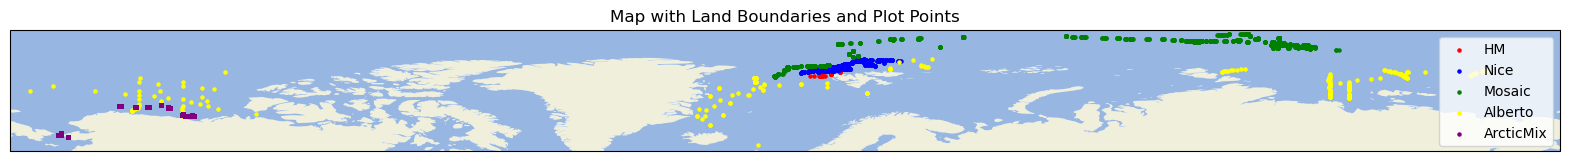

In [74]:
total_profiles = len(HM_ds["longitude"]) + len(nice_ds["longitude"]) + len(mosaic_ds["longitude"]) + len(alberto_ds["longitude"]) + len(arctic_ds["longitude"])
print("total amount of profiles is: ", total_profiles)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label = "HM")
ax.scatter(nice_ds["longitude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label = "Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label = "Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label = "ArcticMix")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()

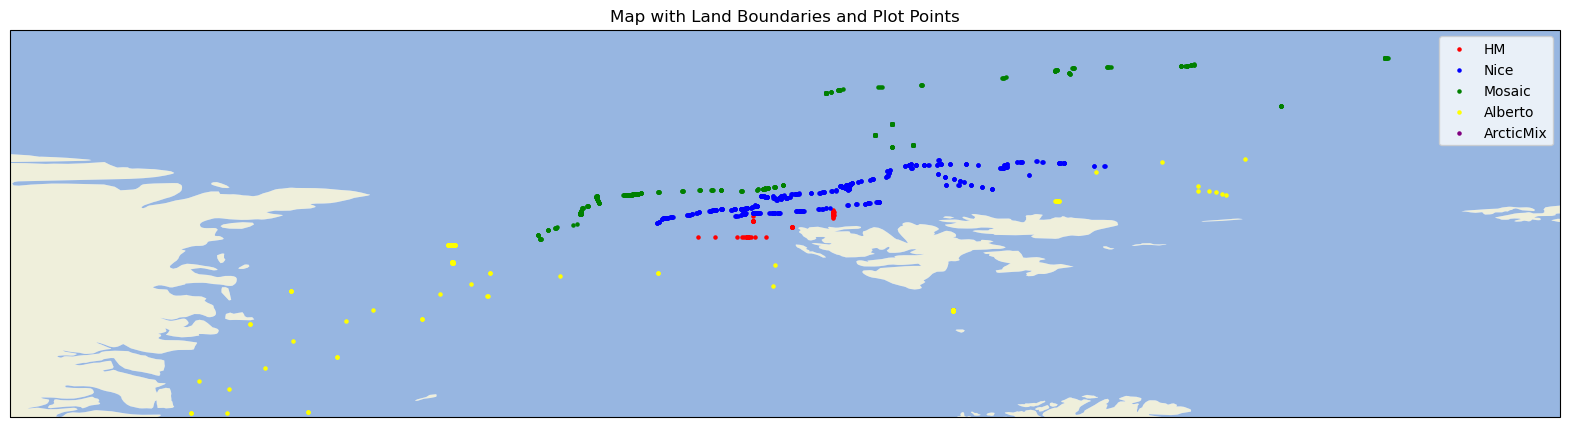

In [76]:
# focus on the Svalbard Islands
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label = "HM")
ax.scatter(nice_ds["longitude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label = "Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label = "Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label = "ArcticMix")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-30, 50, 70, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()


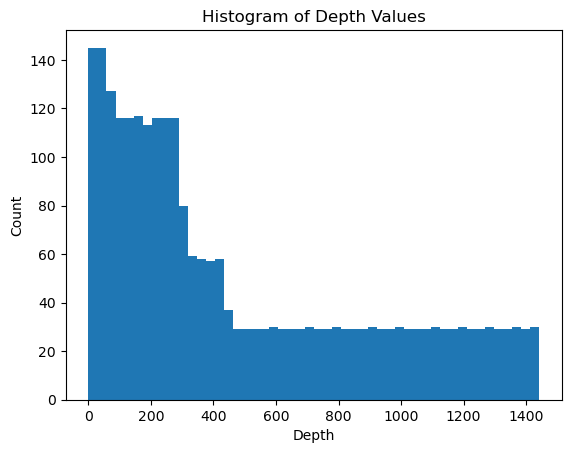

In [77]:
# Select the depth variable from each dataset
depth1 = arctic_ds['depth'].sel()
depth2 = alberto_ds['depth'].sel()
depth3 = nice_ds['depth'].sel()
depth4 = mosaic_ds['depth'].sel()
depth5 = HM_ds['depth'].sel()

# Concatenate the depth values into a single array
depth_values = np.concatenate([depth1.values, depth2.values, depth3.values, depth4.values, depth5.values])

# Plot a histogram of the combined depth values
plt.hist(depth_values, bins=50)
plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Histogram of Depth Values')
plt.show()

## Concatenate the datasets
Remember to show what dataset is from which cruise in this part of the processing

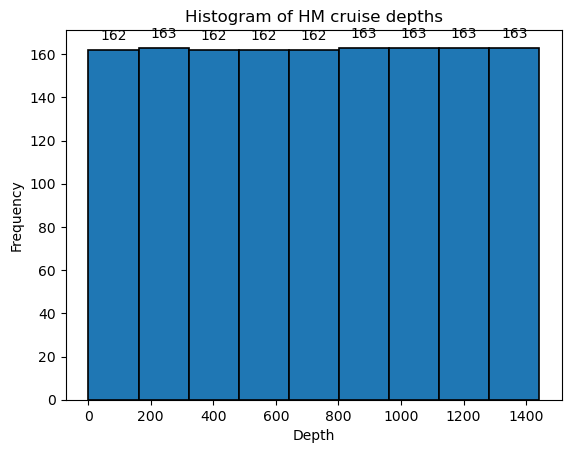

In [136]:
# take the max depth for every profile
max_depths = HM_ds.depth.values
fig, ax = plt.subplots()
n, bins, patches = plt.hist(max_depths, bins=9, edgecolor='black', linewidth=1.2)
# Add labels and title
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Histogram of HM cruise depths')

# Add text labels to each bin
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    ax.annotate(str(int(y)), xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.show()

# From now on, pretend like nice_ds is the combined_ds


In [78]:
combined_ds = mosaic_ds

In [79]:
combined_ds

<xarray.Dataset>
Dimensions:      (profile: 1684, depth: 440)
Dimensions without coordinates: profile, depth
Data variables: (12/44)
    latitude     (profile) float64 85.44 85.45 85.45 85.95 ... 86.03 86.03 86.03
    longitude    (profile) float64 128.1 127.5 127.5 118.7 ... 35.59 35.59 35.59
    stime        (profile) float64 ...
    gpstime      (depth, profile) float64 ...
    gpslat       (depth, profile) float64 ...
    gpslon       (depth, profile) float64 ...
    ...           ...
    covar1       (depth, profile) float64 ...
    covar2       (depth, profile) float64 ...
    krho         (depth, profile) float64 ...
    Re_b         (depth, profile) float64 ...
    L_oz         (depth, profile) float64 ...
    krho_s       (depth, profile) float64 ...
Attributes:
    author:          Kirstin Schulz, Volker Mohrholz, Ilker Fer et al.
    contact:         kiki.schulz@utexas.edu
    created:         04-Apr-2022 15:42:44
    description:     MSS turbulent microstructure data MOSAiC
    cruise:          MOSAiC (Arctic Ocean), Sep 2019 - Sep 2020
    postprocessing:  MSP matlab toolbox (contact: volker.mohrholz@io-warnemue...

# Omit NaNs
omit NaNs for T,S,eps

In [49]:
# stuk minder goed
def mask_nan(dataset):
    # Make sure there are no nans
    mask = np.isnan(dataset.T)*np.isnan(dataset.S)*np.isnan(dataset.eps)
    dataset["T"] = xr.where(mask,np.nan,dataset.T)
    dataset["S"] = xr.where(mask,np.nan,dataset.S)
    dataset["eps"] = xr.where(mask,np.nan,dataset.eps)
    return dataset

In [111]:
data = combined_ds

In [121]:
mask = data.where(np.any(np.isnan(data[['T', 'S', 'eps']])), drop=True)

In [122]:
data = data.sel(depth=mask.depth)

In [124]:
mask = data.where(np.any(np.isnan(data[['T', 'S', 'eps']])), drop=True)
data = mask.dropna(dim='depth', subset=['T', 'S', 'eps'])

In [125]:
n_nans = np.isnan(data.T).sum().values
n_nans

array(0)

In [113]:
for entry_name in data.coords['depth']:
    data.loc[{'depth': entry_name}] = data.sel(depth=entry_name).dropna(dim='time', subset=['T', 'S', 'eps'])

ValueError: time must be a single dataset dimension

In [110]:
data.T

<xarray.DataArray 'T' (depth: 440, profile: 0)>
array([], shape=(440, 0), dtype=float64)
Dimensions without coordinates: depth, profile
Attributes:
    Unit:         degree Celsius
    Description:  in-situ temperature (PT100)

In [106]:
data.T.plot()

TypeError: No numeric data to plot.

In [69]:
#mask = 1-(np.isnan(combined_ds.eps.values) | np.isnan(combined_ds.T.values) | np.isnan(combined_ds.S.values) )
# Make sure there are no nans
mask = np.isnan(combined_ds.T)*np.isnan(combined_ds.S)*np.isnan(combined_ds.eps)
print(mask)
#combined_ds["T"] = xr.where(mask,np.nan,combined_ds.T)
#combined_ds["S"] = xr.where(mask,np.nan,combined_ds.S)
#combined_ds["eps"] = xr.where(mask,np.nan,combined_ds.S)

#combined_ds["T"] = combined_ds["T"][mask,:]
#combined_ds["S"] = combined_ds["S"][mask,:]
#combined_ds["eps"] = combined_ds["eps"][mask,:]
combined_ds['T'] = xr.where(mask,np.nan,combined_ds.T)
combined_ds['S'] = xr.where(mask,np.nan,combined_ds.S)
combined_ds['eps'] = xr.where(mask,np.nan,combined_ds.eps)

<xarray.DataArray (depth: 300, profile: 588)>
array([[False,  True,  True, ...,  True, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * profile  (profile) float32 1.101e+03 1.102e+03 ... 1.687e+03 1.688e+03
  * depth    (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0


## Calculate features like in Mashayek et al. (2021)

In [130]:
def TS_derivative(dataset):
  dataset["dTdz"] = dataset.T.differentiate('depth')
  dataset['dSdz'] = dataset.S.differentiate('depth')
  return dataset

In [141]:
from matplotlib import colors

# define function to calculate N2
def calc_N2(rho, drho, deps):
    return (9.81 / rho) * drho / deps

def calc_N2_kappa(dataset):
    S = dataset.S
    p = dataset.P
    lon = dataset.longitude
    lat = dataset.latitude
    T = dataset.T
    eps = dataset.eps
    z = dataset.depth
    
    dataset['rho'] = gsw.rho(S, T, p)
    dataset["P"] = gsw.conversions.p_from_z(dataset["depth"],
                                            dataset["latitude"])
    dataset['drhodz'] = dataset.rho.differentiate('depth')
    dataset['depsdz'] = dataset.eps.differentiate('depth')
    
    # Calculate N^2
    g = 9.81  # acceleration due to gravity
    
    # apply the calc_N2() function to the DataArray
    N2_da = xr.apply_ufunc(calc_N2, dataset.rho, dataset.drhodz, dataset.depsdz,
                           input_core_dims=[['depth'], ['depth'], ['depth']],
                           output_core_dims=[['depth']],
                           vectorize=True)

    # add the N2 DataArray to the original dataset
    dataset['N2'] = N2_da
    dataset['kappa'] = 0.2*dataset.eps/dataset.N2
    dataset["log_N2"] = np.log10(dataset.N2)
    dataset["log_kappa"] = np.log10(dataset.kappa)
    return dataset

In [139]:
combined_ds = mosaic_ds

<xarray.DataArray 'depsdz' (depth: 440, profile: 1684)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: depth, profile


/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


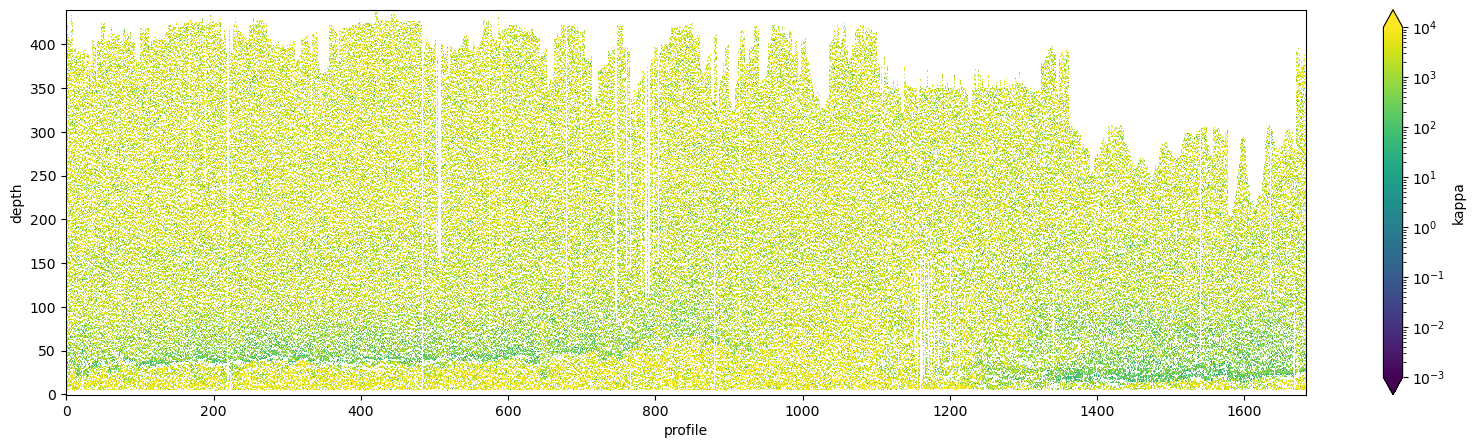

In [140]:
#combined_ds = arctic_ds
combined_ds = calc_N2_kappa(combined_ds)
combined_ds = TS_derivative(combined_ds)
combined_ds.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-3, vmax = 10000),cmap='viridis',figsize=(20,5))

In [144]:
combined_ds = nice_ds
combined_ds = calc_N2_kappa(combined_ds)
combined_ds = TS_derivative(combined_ds)
combined_ds.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-20, vmax = 1e-4),cmap='viridis',figsize=(20,5))

KeyboardInterrupt: 

/var/folders/nn/7hvkdmmn3c15btn2lqvyf2800000gq/T/ipykernel_6414/614808365.py:5: RuntimeWarning: divide by zero encountered in divide
  return (9.81 / rho) * drho / deps
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


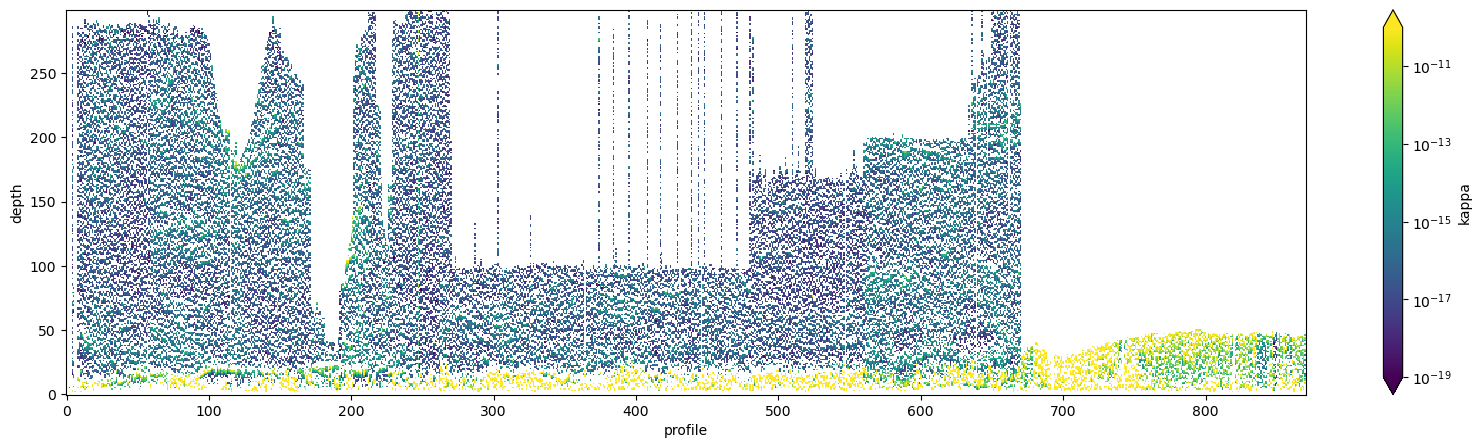

In [145]:
combined_ds = arctic_ds
combined_ds = calc_N2_kappa(combined_ds)
combined_ds = TS_derivative(combined_ds)
combined_ds.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-19, vmax = 1e-10),cmap='viridis',figsize=(20,5))

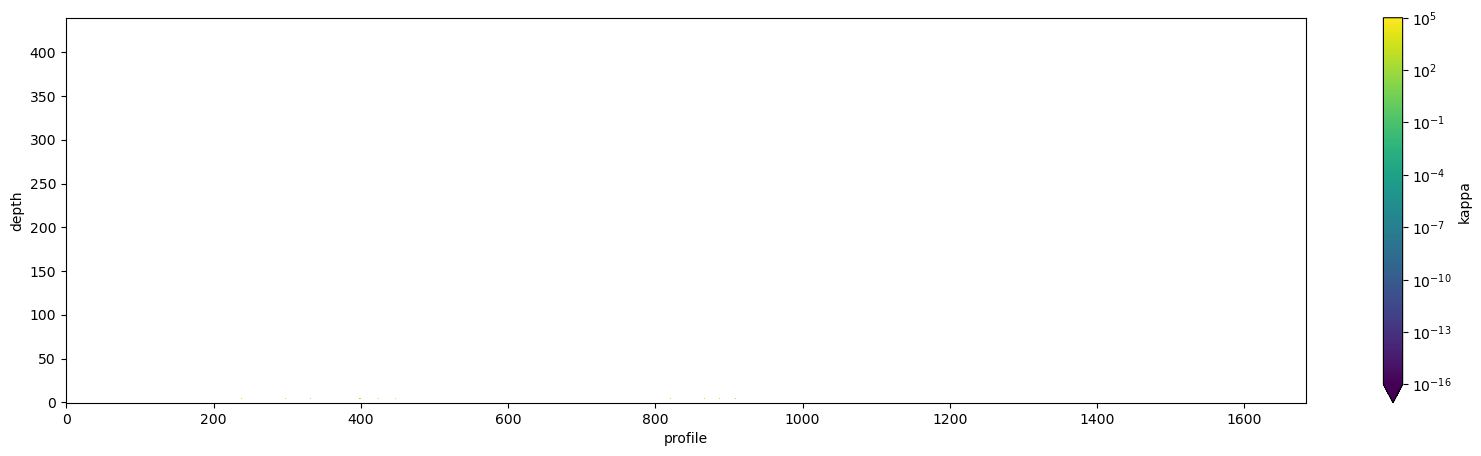

In [147]:
combined_ds = mosaic_ds
combined_ds = TS_derivative(combined_ds)
combined_ds = calc_N2_kappa(combined_ds)
combined_ds.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-16, vmax = 1e05),cmap='viridis',figsize=(20,5))

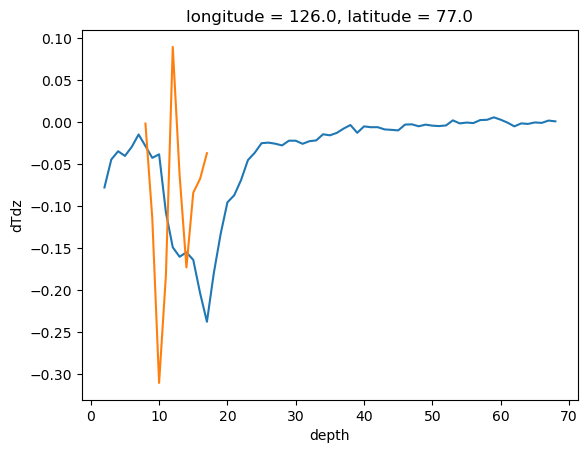

In [166]:
alberto_ds = TS_derivative(alberto_ds)
alberto_ds.dTdz.mean(dim="profile").plot()
alberto_ds.dTdz[:,6].plot()

## Hab

In [148]:
GEBCO_ds = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/gebco_2022_n80.0_s63.0_w-170.0_e-130.0.nc"
#bathy_dataset = Dataset(GEBCO_ds)
bathy_ds = xr.open_dataset(GEBCO_ds)

In [155]:
data = alberto_ds

In [158]:
from tqdm import tqdm

In [189]:
data.longitude.ndim

1

In [207]:
def microlonlat_1d(data):
    microlon = data.longitude[i].values.flatten()
    microlat = data.latitude[i].values.flatten()
    return microlon, microlat

def microlonlat_1d(data):
    microlon = data.longitude[i].values.flatten()[0]
    microlat = data.latitude[i].values.flatten()[0]
    return microlon, microlat

def calc_hab(data):
    bathy_interp = bathy_ds.interp_like(data, method='nearest')
    n_profiles = data.profile.shape[0]
    profiles = np.zeros(n_profiles)
    print(n_profiles)
    print(data.profile.shape)
    
    for i in tqdm(range(n_profiles)):
        microlon = data.longitude[i].values.flatten()[0]
        print(microlon)
        microlat = data.latitude[i].values.flatten()[0]
        profiles[i] = bathy_interp.elevation.sel(lon=microlon,lat=microlat, method='nearest')
    data['bathymetry'] = data.profile.copy(data=profiles)
    
    return data

In [205]:


def calc_hab(data):
    bathy_interp = bathy_ds.interp_like(data, method='nearest')
    n_depths = data.profile.shape[0]
    depth = np.zeros(n_depths)

    for i in tqdm(range(n_depths)):
        microlon = data.longitude[i].values.flatten()[0]
        microlat = data.latitude[i].values.flatten()[0]
        depth[i] = bathy_interp.elevation.sel(lon=microlon,lat=microlat, method='nearest')
    data['bathymetry'] = data.profile.copy(data=depth)
    
    return data

In [208]:
ff = calc_hab(alberto_ds)

351
(351,)


 17%|█▋        | 58/351 [00:00<00:00, 579.78it/s]

125.894433
125.894433
125.89135
125.887567
125.994717
125.994517
125.994133
125.994217
125.992333
125.9928
125.985033
125.9692
125.965233
125.71775
125.7105
125.964133
125.987333
138.6272
139.5955
140.304433
140.908467
141.54775
142.203
142.472
142.701733
143.002433
143.51105
143.506317
144.010567
144.009567
144.009333
158.588767
159.017917
159.402933
159.4156
159.33055
159.938583
161.231183
161.9667
162.525117
148.006117
144.0198
144.053367
144.09035
144.109083
142.412483
142.5842
142.339617
137.6861
135.540483
132.380483
130.470583
128.3403
130.5005
130.501117
130.499467
130.4976
130.494017
130.4904
130.486983
130.483633
130.4531
130.44005
130.43385
130.4829
130.47975
130.494617
130.491
130.483
130.502333
130.50135
130.49985
130.498483
130.487433
130.484467
130.48155
130.509483
130.50955
130.509483
130.509433
130.5128
130.513533
130.5142
130.514767
130.499767
130.499167
130.49855
130.497917
130.500067
130.499233
130.498317
130.4974
130.4965
125.994633
125.991783
125.99035
125.99565
1

 34%|███▍      | 120/351 [00:00<00:00, 602.19it/s]

140.074817


 52%|█████▏    | 181/351 [00:00<00:00, 585.07it/s]

141.224067
143.542783
158.779
161.24825
126.027667
126.0371
103.5702
104.583317
105.350233
106.268617
103.022483
102.531783
102.029167
101.39045
101.395
100.962867
100.966367
31.32105
31.328383
-122.90945
-131.866667
-134.008983
-135.919967
-139.990167
-150.30205
-151.025833
-151.627117
-151.73095
-151.772083
-151.766317
-150.012717
-150.029267
-149.97975
-149.983033
-153.324317
-150.074833
-145.021583
-140.033767
-140.0208
-139.96805
-139.989433
-139.99715
-140.007517
-138.012083
-139.973917
-143.30595
-146.6585
-145.194133
-145.624917
-149.966083
-130.127433
-139.978133
-149.984283
-160.257433
-170.049
-175.291467
-139.9495
-135.419533
-132.630633
-135.437033
-134.2644
-6.49015
-17.7006
-17.692433
-19.56425
-20.654167
-20.646833
-18.789117
-14.616033
-14.627267
-18.718733
-20.254383
-16.859067
-13.109433
-13.13655
-15.417517
-17.601867
-17.60075
-12.675633
-8.741267
-8.75685
-11.27
-15.485883
-15.485883
-15.485767
-7.789983
-5.349133
-5.370917
-6.1891
-7.121683
-7.118733
-7.116083
-7

100%|██████████| 351/351 [00:00<00:00, 615.30it/s]

-7.27425
-7.289567
-7.31035
-7.323183
-7.33775
-7.337417
-7.342217
-7.352317
-7.366083
-7.378
-7.386917
-7.39925
-7.414183
-7.14445
-7.159467
-7.16665
-7.1728
-7.18145
-7.193983
-7.2015
-7.205733
-7.210183
-7.213517
-7.218767
-7.2237
-5.230767
-5.243817
-1.629633
3.43765
3.443633
9.505833
24.115933
24.104483
24.096467
24.08775
24.078617
24.065983
24.120517
24.032317
24.132783
24.013267
23.987633
23.965367
23.943167
33.740383
29.464067
26.05635
31.869
32.259233
32.56345
32.75385
18.667183
18.66455
18.661233
18.65795
18.655317
18.6531
18.65105
18.650617
18.650367
18.650317
18.650467
18.650933
18.651383
18.65185
18.652217
18.652683
18.65325
18.6538
18.655867
18.656317
18.656933
18.6574
18.65735
18.658167
18.65885
18.65935
18.6597
18.6602
18.661867
18.662733
18.663117
18.663667
18.663933
18.66455
18.651083
18.651433
18.651333
18.6511
18.650733
18.650967
18.651383
18.651733
18.652517
18.652867
18.653367
18.653867
18.653933
18.654133
18.654383
18.655017
18.65555
18.656
18.65635
18.656783
9.3

In [209]:
ff = calc_hab(arctic_ds)

871
(871,)


  3%|▎         | 30/871 [00:00<00:02, 295.62it/s]

-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036

  9%|▉         | 77/871 [00:00<00:02, 396.22it/s]

-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008


 13%|█▎        | 117/871 [00:00<00:01, 384.53it/s]

-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036

 18%|█▊        | 156/871 [00:00<00:02, 329.19it/s]

-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008


 25%|██▌       | 219/871 [00:00<00:02, 230.66it/s]

-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008


 34%|███▍      | 294/871 [00:01<00:01, 299.78it/s]

-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036414008
-166.5914036

 34%|███▍      | 300/871 [00:01<00:01, 294.34it/s]

-166.5914036414008
-166.5914036414008


IndexError: index 300 is out of bounds for axis 0 with size 300

## To do
- sort and omit NaNs
- profile, maybe can rename
- gamma and N2